# 1. Paper and Group Details

**Paper Title:** Duplex Generative Adversarial Network for Unsupervised Domain Adaptation - CVPR 2018

**Authors:** Lanqing Hu, Meina Kan, Shiguang Shan, Xilin Chen

**Link:** http://openaccess.thecvf.com/content_cvpr_2018/papers/Hu_Duplex_Generative_Adversarial_CVPR_2018_paper.pdf

**Group Members:** Cem Önem, Cansu Cemre Yeşilçimen

Contact Information can be found in the README.

**Reviewers:** Y.Berk Gültekin, Hasan Ali Duran

# 2. Goals

Our results can be compared with the original results at the last section of the notebook.

## 2.1. Quantitative Results

We planned to meet the classification accuracy of the architecture mentioned in Table 1, 2nd row from the bottom, 3rd column from the left (92.46%), where the model was trained on SVHN dataset with labels + unlabeled MNIST dataset, and tested against the MNIST dataset (SVHN -> MNIST) to show the domain adaptation quality. We plan to reproduce similar results with digits 0-4 to cut down on dataset size.

## 2.2. Qualitative Results

We planned to reproduce Figure 4, where the model and the training is the same as the quantitative results, however this time SVHN images are fed into the network to generate images similar to the ones in MNIST, where digit category is preserved (for digits 0-4)

# 3. Paper Summary

## 3.1 Problem Statement

As models scale up, collecting new training data to train models becomes more and more expensive. Transfer learning is a remedy technique to this complication where the model exploits its experience gained from training for other tasks that are similar to the one at hand.

DupGAN mainly tackles the issue of **unsupervised domain adaptation**, a subset of Transfer Learning in which there are two domains that share categories but have different data distrubutions. **The ground truth labels are only available for one of the domains** (the source domain), therefore the model is expected to utilize the sample-label relation of this domain to unsupervisedly classify the samples of the other domain (the target domain).

In our reproduction we will treat these domains as follows:
- Source domain training data: SVHN train set digit images + labels for digits 0-4
- Target domain training data: MNIST train set digit images for digits 0-4
- Target domain test data (for classification): MNIST test set digit images for digits 0-4

## 3.2 Definitions and Model Architecture Overview
Let the source domain training data be denoted as $S = \{(x^s_i, y^s_i)\}^n_{i=1}$ with source images $X^s = \{x^s_i\}^n_{i=1}$ and labels $Y^s = \{y^s_i\}^n_{i=1}$. Each $y^s \in Y^s$ correspond to a label in the set $B = \{b_0,\ b_1...b_c\}$ with cardinality $c$. Let the target domain training data be denoted as $X^t = \{x^t_i\}^m_{i=1}$. **Note that there is no $Y^t$.**

DupGAN attempts to better the classification quality by training for category preserving domain translation as well as classification. To that end, a hybrid autoencoder GAN architecture where the generator $G$ with two outputs is put against two discriminators $D^s, D^t$ for the source and the target domains respectively:

<img src="images/architecture.png" />
<center>Figure 1: Overview of DupGAN Architecture</center>

The encoder $E$ at the beginning compresses the images (without any regard to type of domain) into encodings which should be ideally independent of the domain:

\begin{align}
Z^s &= \{z^s \mid E(x^s) = z^s,\ x^s \in X^s \} \\
Z^t &= \{z^t \mid E(x^t) = z^t,\ x^t \in X^t \} \\
Z &= Z^s \cup Z^t
\end{align}

$G$ takes this encoding as well as a domain code $a$ as input, where $a \in \{s, t \}$ indicates the domain type of the image that should be generated. In the end, the following 4 modes of $G$ are integral during training, for $z^s \in Z^s$ and $z^t \in Z^t$:

- source to source, $X^{ss} = \{x^{ss} \mid G(z^s,s) = x^{ss},\ z^s \in Z^s \}$
- target to target, $X^{tt} = \{x^{tt} \mid G(z^t,t) = x^{tt},\ z^t \in Z^t \}$
- source to target, $X^{ss} = \{x^{st} \mid G(z^s,t) = x^{st},\ z^s \in Z^s \}$
- target to source, $X^{ss} = \{x^{ts} \mid G(z^s,s) = x^{ts},\ z^t \in Z^t \}$

The first two are used for assessing reconstruction quality to ensure $E$ and $G$ work properly as an autoencoder. The other two are to deceive $D^s, D^t$ for GAN training. 

Other than telling real images apart from the real ones, the discriminators also categorize the images in the correct labels. To that end, the discriminators categorize images in bins $B' = \{b_0,\ b_1...b_{c+1}\}$ of cardinality $c+1$ with some probabilities $p^s_l, p^t_l$, where first $c$ bins correspond to the labels and the last bin $b_{c+1}$ is reserved for fake images.

\begin{align}
p^{s}_l &= D^s(x,l) & l \in B',\ x \in X^{s} \cup X^{ts} \\
p^{t}_l &= D^t(x,l) & l \in B',\ x \in X^{t} \cup X^{st}
\end{align}

Lastly, there is a classifier $C$ on top of the encodings. It sorts images from both domains into $L$ with some probability $p^c_l$:

\begin{align}
p^c_l &= C(z,l) & l \in B,\ z \in Z
\end{align}

It might seem redundant since the $D^s, D^t$ are also doing classification, but the classifier is necessary for the target domain at the pretraining stage. The purpose of $C$ will become clear in the further sections.

## 3.3. Training Details and Objective Functions for the Modules

### 3.3.1. Pseudolabels for Target Domain

In the following sections, the objective function formulations for the models require labels for both domains. **Since the ground truth labels are missing for the target domain, they are compansated with pseudolabels generated from the classifier $C$**. The high confidence target dataset with supervised labels is defined as follows:

\begin{align}
T &= \{ (x^t,y^{t}) \mid C(E(x^t),y^{t}) > p_{thres},\ x^t \in X^t,\ y^{t} \in B \}
\end{align}

with $X^{t'}$ and $Y^{t'}$ as data and the labels of this constructed dataset. After pretraining (explained below), $T$ replaces $X^{t}$.

$p_{thres}$ is a model hyperparameter (we picked it as 0.99 in our experiments). Note that **$T$ may change at every training step since $C$ might classify the target domain data in a different way. Therefore $T$ is renewed at every epoch of the training step.**

To increase the chances of pseudolabels being accurate, $E$ and $C$ are pretrained solely with $S$ before core DupGAN training loop.

### 3.3.2. Generator Related Losses

The generator $G$ has two purposes:
- Act as an autoencoder with the Encoder $E$, and reconstruct the original image from the encoding:

\begin{align}
L_{recon}(E,G) &= \sum_{x^s \in X^s}||x^s - G(E(x^s),s)|| + \sum_{x^t in X^t}||x^t - G(E(x^t),t)|| \\
       &= \sum_{x^s \in X^s}||x^s - x^{ss})|| + \sum_{x^t \in X^t}||x^t - x^{tt}||
\end{align}

- Decieve the discriminators with fake images generated from the other domain:

\begin{align}
L_{deceive}(E,G) &= \sum_{{(x^s,y^s)} \in S}H_{B'}(D^t(G(E(x^s),t),y^s))+\sum_{{(x^t,y^t)} \in T} H_{B'}(D^s(G(E(x^t),s),y^t)) \\
&= \sum_{{(x^s,y^s)} \in S}H_{B'}(D^t(x^{st},y^s))+\sum_{{(x^t,y^t)} \in T} H_{B'}(D^s(x^{ts},y^t))
\end{align}
with $H_{B'}(\cdot,\cdot)$ as cross-entropy loss along $B'$. **The labels from the other domains are also used to make the discriminator classify the counterfeit images in the correct category other than not being fake.** This forces the generator to preserve the category when translating images. Also note that **$y^t$ are generated with the classifier $C$ since no ground truth is available** for target domain labels.

In the end, the total generator related loss becomes:

\begin{align}
L_{gen}(E,G) &= \alpha L_{recon} + L_{deceive}
\end{align}

where $\alpha$ is a model hyperparameter (we picked it as 40.0).

### 3.3.3. Discriminator Related Losses

The discriminators are not joint in DupGAN. $D^s$ and $D^t$ discriminate source and target images from counterfeit ones generated from the other domain. Both employ the cross-entropy discriminator loss in the original GAN.
- Discriminator $D^s$ has the following loss:
\begin{align}
L_{D^s} &= \sum_{{(x^s,y^s)} \in S}H_{B'}(D^t(x^s,y^s))+\sum_{{x^t} \in X^t} H_{B'}(G(E(x^t),s),b_{c+1})) \\
        &= \sum_{{(x^s,y^s)} \in S}H_{B'}(D^t(x^s,y^s))+\sum_{{x^t} \in X^t} H_{B'}(D(x^{ts},b_{c+1}))
\end{align}
with $b_{c+1}$ representing the fake category.

- Discriminator $D^t$ is similar, **but pseudolabels are used instead of ground truth**:

\begin{align}
L_{D^t} &= \sum_{{(x^t,y^t)} \in T}H_{B'}(D^t(x^t,y^t))+\sum_{{x^s} \in X^s} H_{B'}(G(E(x^s),t),b_{c+1})) \\
        &= \sum_{{(x^t,y^t)} \in T}H_{B'}(D^t(x^t,y^t))+\sum_{{x^s} \in X^s} H_{B'}(D(x^{st},b_{c+1}))
\end{align}

The total discriminator loss is the sum of these losses:

\begin{align}
L_{disc}(D^s,D^t) &= L_{D^s} + L_{D^t}
\end{align}

### 3.3.4. Classifier Related Losses

The training for classifier $C$ continues even after pretraining step:

\begin{align}
L_{cl}(C,E) &= \sum_{(x, y) \in S \cup T}H_{B}(C(E(x),y))
\end{align}

**During pretraining, $T = \emptyset$. After the pretraining ends, $T$ is recalculated at the beginning of every epoch.**

### 3.3.5. Total Loss and the Training Loop

Total loss is as follows:

\begin{align}
L &= \beta L_{cl} + L_{gen} + L_{disc}
\end{align}

with $\beta$ as model hyperparameter (we picked it as 40.0).

The training loop is similar to the one in the original GAN, but with the addition of pretraining part and the pseudolabel calculation step:
<br>
<br>

<center>Algorithm 1: DupGAN Training Loop.</center>
<hr style="border:2px solid gray"> </hr>

**input**: Source domain $S$.and target domain $X^t$ <br>
**output**: Model weights $W_E,\ W_G,\ W_C,\ W_{D^s},\ W_{D^t}$

1: Pretrain $E$ and $C$ with $S$ by backpropping on $L_{cl}$ until convergence: <br>
$W_E \leftarrow W_E - \eta\frac{\delta L_{cl}}{\delta W_E}$ <br>
$W_C \leftarrow W_C - \eta\frac{\delta L_{cl}}{\delta W_C}$

2: **until** convergence, **do** <br>

&emsp;2.1: Calculate $T$.

&emsp;2.2: Backprop on discriminator losses: <br>
&emsp;$W_{D^s} \leftarrow W_{D^s} - \eta\frac{\delta L_{D^s}}{\delta W_{D^s}}$ <br>
&emsp;$W_{D^t} \leftarrow W_{D^t} - \eta\frac{\delta L_{D^t}}{\delta W_{D^t}}$

&emsp;2.2: Backprop on generator and classifier losses: <br>
&emsp;$W_{G} \leftarrow W_{G} - \eta\frac{\delta L_{gen}}{\delta W_G}$ <br>
&emsp;$W_{C} \leftarrow W_{C} - \eta\frac{\delta L_{cl}}{\delta W_C}$ <br>
&emsp;$W_{E} \leftarrow W_{E} - \eta\frac{\delta (L_{cl}+L_{gen}}{\delta W_E}

3: **return** $W_E,\ W_G,\ W_C,\ W_{D^s},\ W_{D^t}$



<hr style="border:2px solid gray"> </hr>

# 4. Implementation

## 4.1 Implementation Difficulties and Differences from the Paper Specifications

Main difficulty we faced was that the architecture of the network was not presented in the original DUPGAN paper. It was described as "similar" to an architecture from an another paper named Unsupervised Image-to-Image Translation Networks (https://arxiv.org/pdf/1703.00848.pdf). Upon investigating this paper, we noticed that DUPGAN and UNIT had some differences regarding main architecture design (such as UNIT learning an actual probability distrubution which was used to sample the latent representation and DUPGAN outputting the latent vectors directly), which forced us to make some minor changes that we thought to be successful. Because of these assumptions and trials we consider this to be the reason of our accuracy result being different from our initial goal. These differences are listed below.

- In UNIT paper, for SVHN -> MNIST change, authors used the extra training set and test set. The original MNIST images were gray-scale. But in UNIT paper they are converted to RGB images and performed a data augmentation where they also used the inversions of the original MNIST images for training. We did not follow this augmentation method and used all images as they were.

- Classifier C in the original DUPGAN paper was not specified, and did not exist at all in UNIT. So we picked it as a fully connected layer on top of the encoder followed by a LeakyRELU layer, as it was the simplest choice.
    
- Regarding the encoder implementation UNIT paper has 1024 channels (neurons since inputs/outputs are 1x1) but those are mu,sigmas that represent a 512x1 latent vector. However DUPGAN does not do any sampling, so 512 channels suffice. We also removed the extra fully connected layer that expands to 1024 nodes owing to this.

- Learning rates are changed for experimental purposes

- Highly confident labels are gathered at each epoch rather than each batch. Since GAN training is already unstable, we wanted to make sure we gathered a statistically more meaningful percentage and overcame the batch size being too small (64) to sample properly.

- Hyperparameters $\alpha$ and $\beta$ of the model are different from the ones specified in the paper. 

## 4.2 Implementation Overview

Hyperparameters and Other Settings are listed here. You may want to change the device field if no gpu support is available.

In [1]:
import torch
import os

from train import EncoderClassifierTrainer, GeneratorDiscriminatorTrainer
from utils import mnist_dataset, svhn_dataset, generic_dataloader
from notebook_utils import *

class Params:
    
    #change to cpu if gpu is not available
    device = 'cuda'
    
    datasets_root = os.path.join('datasets', '')
    
    ckpt_root = os.path.join('ckpts', '')

    # location of pre-trained encoder_classifier file
    encoder_classifier_ckpt_file = 'ckpts/encoder_classifier_16.tar'
    
    # prepended to each saved checkpoint file name for encoder_classifier
    encoder_classifier_experiment_name = 'encoder_classifier_notebook'
    
    # location of pre-trained generator_discriminator file
    generator_discriminator_ckpt_file = 'ckpts/generator_discriminator_99.tar'
    
    # prepended to each saved checkpoint file name for generator_discriminator
    generator_discriminator_experiment_name = 'encoder_classifier_notebook'
    
    # dupgan specific params
    dupgan_alpha = 40.0 #different from the specified value in the paper
    dupgan_beta = 40.0
    encoder_classifier_confidence_threshold = 0.99
    
    # optimizer params
    encoder_classifier_adam_lr = 0.0002
    generator_adam_lr = 0.00002
    discriminator_adam_lr = 0.00001
    encoder_classifier_adam_beta1 = 0.5
    encoder_classifier_adam_beta2 = 0.999
    generator_adam_beta1 = 0.5
    generator_adam_beta2 = 0.999
    discriminator_adam_beta1 = 0.5
    discriminator_adam_beta2 = 0.999
    
    # other training params
    batch_size = 64
    encoder_classifier_num_epochs = 30
    generator_discriminator_num_epochs = 100
    
    # other non-training params
    demo = True #demo mode, training outputs are more frequent
    

params = Params()

In [2]:
# dataloading, missing datasets are automatically downloaded
svhn_trainsplit = svhn_dataset(params.datasets_root, "train")
svhn_testsplit = svhn_dataset(params.datasets_root, "test")
mnist_testsplit = mnist_dataset(params.datasets_root, False)
mnist_trainsplit = mnist_dataset(params.datasets_root, True)

Using downloaded and verified file: datasets/train_32x32.mat
Using downloaded and verified file: datasets/test_32x32.mat


The Encoder - Classifier architecture is as follows. It has 2 outputs, an encoding of the input and a confidence vector from this encoding for digit classification.

In [3]:
encoder_classifier_trainer = EncoderClassifierTrainer(params.device, params,
                                    svhn_trainsplit, svhn_testsplit, mnist_trainsplit, mnist_testsplit,
                                    ckpt_root=params.ckpt_root)
print(encoder_classifier_trainer.encoder_classifier)

EncoderClassifier(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(8, 8), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (latent): Linear(in_features=256, out_features=512, bias=True)
  (classifier): Sequential(
    (0): LeakyReLU(negative_slope=0.01)
    (1): Linear(in_features=512, out_features=5, bias=True)
  )
)


Pretraining is straightforward, the model is trained only with respect to the labels from the same domain (in our case SVHN digit images and digit labels) at this stage. Here is the training procedure for one batch:

In [4]:
def encoder_classifier_notebook_train_one_batch(self, batch):
    inputs, labels = batch
    inputs = inputs.to(self.device)
    labels = labels.to(self.device)

    self.optimizer.zero_grad()
    
    # output is a 1x5 vector of confidences for digits [0-4] (not normalized)
    classifier_out, _ = self.encoder_classifier(inputs)
    
    # criterion is cross-entropy loss against labels on top of a softmax layer
    loss = self.criterion(classifier_out, labels)
    loss.backward()
    
    #optimizer is ADAM
    self.optimizer.step()

The training procedure finds context as follows. The model is saved and evaluated after every epoch in the code below, but you are free to modify it to your liking.

In [5]:
def encoder_classifier_notebook_train_model(self):
    self.encoder_classifier.train()
    
    #initial self.epoch value is taken from saved checkpoint, it is -1 for a brand new model. 
    for self.epoch in range(self.epoch+1, params.encoder_classifier_num_epochs):
        for batch in self.svhn_trainsplit_loader:
            
            encoder_classifier_notebook_train_one_batch(self, batch)
            
            if params.demo:
                encoder_classifier_notebook_evaluator_evaluate_and_print(self)
        
        encoder_classifier_notebook_evaluator_evaluate_and_print(self)
        #saved every epoch under ckpt_root
        self.save()

try:
    encoder_classifier_notebook_evaluator_reset()
    encoder_classifier_notebook_train_model(encoder_classifier_trainer)
except KeyboardInterrupt:
    pass

Epoch,SVHN Train Split Loss,SVHN Train Split Classification Acc. (%),SVHN Test Split Classification Acc. (%),MNIST Train Split Above Threshold (%)
0,1139.7694,29.1539,28.4381,0.0000
0,1138.3447,30.0139,30.7190,0.0000
0,1135.7645,30.0381,30.4995,0.0000


The "pretrained" model for pretraining can be loaded with the snippet below. You can also load the model you have trained above by changing the path.

In [6]:
#encoder_classifier_trainer.load("absolute path to model.tar that you may have
#                                 trained above and would like to continue training")
encoder_classifier_notebook_load_and_print_params(encoder_classifier_trainer, params.encoder_classifier_ckpt_file)

ADAM learning rate: 0.0002
ADAM betas: (0.5, 0.999)
epoch: 16
experiment_name: encoder_classifier


Here are the classification results for the pretrained model. About 79% of the MNIST dataset is confidently classified with the classifier pretrained only with SVHN dataset.

In [7]:
encoder_classifier_notebook_evaluator_reset()
encoder_classifier_notebook_evaluator_evaluate_and_print(encoder_classifier_trainer)

Epoch,SVHN Train Split Loss,SVHN Train Split Classification Acc. (%),SVHN Test Split Classification Acc. (%),MNIST Train Split Above Threshold (%)
16,12.9597,99.4090,92.6511,79.6379


The pretrained Encoder - Classifier is later embedded to the actual GAN architecture below. Here is the Generator architecture. Notice the extra 513th dimension in the first layer accounting for the domain code that the generator takes as an extra input.

In [8]:
encoder_classifier = encoder_classifier_trainer.encoder_classifier
encoder_classifier_optimizer = encoder_classifier_trainer.optimizer
generator_discriminator_trainer = GeneratorDiscriminatorTrainer(params.device, params, 
                                                                encoder_classifier,
                                                                encoder_classifier_optimizer, 
                                                                svhn_trainsplit,
                                                                svhn_testsplit, mnist_trainsplit, mnist_testsplit,
                                                                experiment_name=params.generator_discriminator_experiment_name,
                                                                ckpt_root=params.ckpt_root)
print(generator_discriminator_trainer.generator)

Generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(513, 256, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (layer4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tanh): Tanh()
)


The architecture of the Discriminators (they are identical):

In [9]:
print(generator_discriminator_trainer.discriminator_svhn)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (discrimina

The training procedure for the discriminators is as follows for a pair of batches from both domains. Note that the labels for the MNIST batches are not coming from the dataset, but the Encoder - Classifier of the model itself.

In [10]:
def discriminator_mnist_notebook_train_one_batch(self, svhn_batch, mnist_hc_batch):
    
    svhn_inputs, _ = svhn_batch # don't care about svhn labels here
    mnist_hc_inputs, mnist_hc_labels = mnist_hc_batch
    # mnist_hc_labels are high confidence digit labels obtained from the classifier, not ground truth

    # a utility method to zero all grads in all models
    self.zero_grad()
    
    # generate fake mnist images from encodings of svhn images
    _, svhn_latent_out = self.encoder_classifier(svhn_inputs)
    svhn_to_fake_mnist = self.generator(svhn_latent_out, 1)

    # discriminator output is a 1x6 (not 1x5!) vector of confidences for digits [0-4] and fake (not normalized)
    
    # fake image confidences, discriminator has less loss if the 6th item is large 
    svhn_to_fake_mnist_discriminator_out = self.discriminator_mnist(svhn_to_fake_mnist)
    
    # real image confidences, discriminator has less loss if item matching the high conf. classifier label is large
    real_mnist_discriminator_out = self.discriminator_mnist(mnist_hc_inputs)

    # criterion is cross-entropy loss against labels on top of a softmax layer
    
    # fake image loss is against fake labels (label "5")
    discriminator_mnist_fake_loss = self.discriminator_mnist_criterion(svhn_to_fake_mnist_discriminator_out,
                                     self.fake_label_pool[:svhn_to_fake_mnist_discriminator_out.shape[0]])

    # real image loss is against high confidence classifier labels
    discriminator_mnist_real_loss = self.discriminator_mnist_criterion(real_mnist_discriminator_out,
                                                                       mnist_hc_labels)

    # total loss
    discriminator_mnist_loss = discriminator_mnist_fake_loss + discriminator_mnist_real_loss

    discriminator_mnist_loss.backward()
    self.discriminator_mnist_optimizer.step()

The discriminator training procedure for SVHN dataset, where we have the ground truth, is very similar to the discriminator of MNIST. Only this time actual ground truth is available for calculating the loss on real SVHN images.

In [11]:
def discriminator_svhn_notebook_train_one_batch(self, svhn_batch, mnist_hc_batch):

    svhn_inputs, svhn_labels = svhn_batch # we have the ground truth digit labels for svhn in training
    mnist_hc_inputs, _ = mnist_hc_batch # don't care about mnist labels here
    
    self.zero_grad()
    
    # generate fake svhn images from encodings of mnist images
    _, mnist_hc_latent_out = self.encoder_classifier(mnist_hc_inputs)
    mnist_to_fake_svhn = self.generator(mnist_hc_latent_out, 0)

    # discriminator output is a 1x6 (not 1x5!) vector of confidences for digits [0-4] and fake (not normalized)
    
    # fake image confidences, discriminator has less loss if the 6th item is large 
    mnist_to_fake_svhn_discriminator_out = self.discriminator_svhn(mnist_to_fake_svhn)
    
    # real image confidences, discriminator has less loss if item matching the ground truth svhn label is large
    real_svhn_discriminator_out = self.discriminator_svhn(svhn_inputs)

    # criterion is cross-entropy loss against labels on top of a softmax layer
    
    # fake image loss is against fake labels (label "5"), optimizer pulls discriminator towards guessing correctly
    discriminator_svhn_fake_loss = self.discriminator_svhn_criterion(mnist_to_fake_svhn_discriminator_out,
                                    self.fake_label_pool[:mnist_to_fake_svhn_discriminator_out.shape[0]])

    # real image loss is against ground truth svhn labels, optimizer pulls discriminator towards guessing correctly
    discriminator_svhn_real_loss = self.discriminator_svhn_criterion(real_svhn_discriminator_out,
                                                                     svhn_labels)
    
    # total loss
    discriminator_svhn_loss = discriminator_svhn_fake_loss + discriminator_svhn_real_loss

    discriminator_svhn_loss.backward()
    self.discriminator_svhn_optimizer.step()

Generator and the encoder - classifier are trained with the following procedure. The generator has two losses, the first one is for deceiving the discriminators and the second one the reconstruction loss for the reconstructed encodings (the reconstructions do not change domain).

In [12]:
def generator_classifier_notebook_train_one_batch(self, svhn_batch, mnist_hc_batch):
    
    svhn_inputs, svhn_labels = svhn_batch # we have the ground truth digit labels for svhn in training
    mnist_hc_inputs, mnist_hc_labels = mnist_hc_batch
    # mnist_hc_labels are high confidence digit labels obtained from the classifier, not ground truth
    
    self.zero_grad()
    
    # generate fake images (from the other domain) and reconstructed images (from the same domain)
    # from the encodings
    
    # classifier confidences will be used for classifier training
    mnist_hc_classifier_out, mnist_hc_latent_out = self.encoder_classifier(mnist_hc_inputs)
    svhn_classifier_out, svhn_latent_out = self.encoder_classifier(svhn_inputs)

    svhn_to_fake_svhn = self.generator(svhn_latent_out, 0)
    svhn_to_fake_mnist = self.generator(svhn_latent_out, 1)
    mnist_to_fake_svhn = self.generator(mnist_hc_latent_out, 0)
    mnist_to_fake_mnist = self.generator(mnist_hc_latent_out, 1)
    
    # 1-) Generator Training
    
    # 1-a) Generator Deception Losses
    
    # discriminator output is a 1x6 (not 1x5!) vector of confidences for digits [0-4] and fake (not normalized)

    svhn_to_fake_mnist_discriminator_out = self.discriminator_mnist(svhn_to_fake_mnist)
    mnist_to_fake_svhn_discriminator_out = self.discriminator_svhn(mnist_to_fake_svhn)
    
    # deception criterion is cross-entropy loss against labels on top of a softmax layer
    
    # fake mnist image losses are against ground truth svhn labels
    # optimizer pulls generator towards making discriminator categorize fake mnist images incorrectly
    # in the corresponding ground truth svhn labels
    deceive_discriminator_mnist_loss = self.generator_deception_criterion(
        svhn_to_fake_mnist_discriminator_out, svhn_labels)
    
    # fake svhn image losses are against mnist high conf. classifier labels (not ground truth)
    # optimizer pulls generator towards making discriminator categorize fake svhn images incorrectly
    # in the corresponding mnist high conf. classifier labels (not ground truth)
    deceive_discriminator_svhn_loss = self.generator_deception_criterion(
        mnist_to_fake_svhn_discriminator_out, mnist_hc_labels)
    
    # total deception loss
    deception_loss = deceive_discriminator_mnist_loss + deceive_discriminator_svhn_loss
    
    # 1-b) Generator Reconstruction Losses
    
    # reconstructed images should look like the original images, reconstruction criterion is
    # L2 loss between original and reconstructed images - no label information used
    
    reconstruction_mnist_loss = self.generator_reconstruction_criterion(mnist_to_fake_mnist,
                                                                        mnist_hc_inputs)
    reconstruction_svhn_loss = self.generator_reconstruction_criterion(svhn_to_fake_svhn,
                                                                       svhn_inputs)
    
    # total reconstruction loss
    reconstruction_loss = reconstruction_mnist_loss+reconstruction_svhn_loss
    
    # total generator loss, there is a reconstruction loss scaling parameter alpha specified in the paper
    generator_loss = deception_loss + self.dupgan_alpha*reconstruction_loss
    
    
    # 2-) Classifier Training
    
    # criterion is cross-entropy loss against labels from own domain, same as pretraining, only difference is
    # mnist high confidence images also contribute to the loss with mnist high confidence labels (not ground truth)
    
    mnist_classification_loss = self.encoder_classifier_criterion(mnist_hc_classifier_out, mnist_hc_labels)
    svhn_classification_loss = self.encoder_classifier_criterion(svhn_classifier_out, svhn_labels)

    # total classification loss, there is a scaling parameter beta specified in the paper
    classification_loss = self.dupgan_beta*(mnist_classification_loss + svhn_classification_loss)

    generator_ec_loss = generator_loss + classification_loss
    generator_ec_loss.backward()

    self.generator_optimizer.step()
    self.encoder_classifier_optimizer.step()

The 3 procedures collect in the following main training loop. At the beginning of each epoch, the filtered collection of MNIST images with high classification confidence are renewed. The model is saved and evaluated at every epoch. You can change the frequency of these to your liking by playing with the code below.

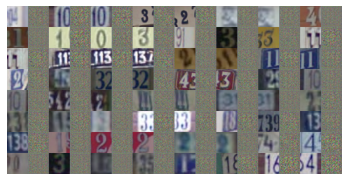

Epoch,Discriminator Loss,Generator Deception Loss,Generator Reconstruction Loss,Generator Loss,MNIST High Conf. Sample Count
0,0.0558,0.0281,0.2366,0.2647,24366
0,0.0557,0.0281,0.2418,0.2700,24366
0,0.0555,0.0282,0.2554,0.2836,24366


In [13]:
def generator_discriminator_notebook_train_models(self):
    
    for self.epoch in range(self.epoch+1, params.generator_discriminator_num_epochs):
        
        # at the beginning every epoch review images in the mnist train split and collect the ones
        # that the classifier has high confidence in categorization
        # train the models with inferred label - high confidence mnist image pairs
        # as if the inferred labels are ground truth
        mnist_hc_dataset, pseudolabels = self.get_high_confidence_mnist_dataset_with_pseudolabels()
        mnist_hc_loader = generic_dataloader(self.device, mnist_hc_dataset, shuffle=True,
                                             batch_size=self.batch_size)
        
        # since mnist is smaller than svhn, have to use iterators to jointly train
        mnist_ind = 0
        mnist_iterator = iter(mnist_hc_loader)
        for svhn_batch in self.svhn_trainsplit_loader:
            
            # hack to skip 1 sample batches since they give an error with batchnorm
            # device compatibility code, etc.
            while True:
                if mnist_ind >= len(mnist_iterator):
                    mnist_iterator = iter(mnist_hc_loader)
                    mnist_ind = 0
                mnist_hc_inputs, *_, mnist_hc_indices = next(mnist_iterator)
                mnist_ind += 1
                if mnist_hc_inputs.shape[0] > 1:
                    break
            mnist_hc_inputs = mnist_hc_inputs.to(self.device)
            mnist_hc_labels = pseudolabels[mnist_hc_indices].to(self.device)
            svhn_inputs, svhn_labels = svhn_batch
            svhn_inputs = svhn_inputs.to(self.device)
            svhn_labels = svhn_labels.to(self.device)
            
            #meat of the training code
            mnist_hc_batch = (mnist_hc_inputs, mnist_hc_labels)
            svhn_batch = (svhn_inputs, svhn_labels)
            
            discriminator_mnist_notebook_train_one_batch(self, svhn_batch, mnist_hc_batch)
            discriminator_svhn_notebook_train_one_batch(self, svhn_batch, mnist_hc_batch)
            generator_classifier_notebook_train_one_batch(self, svhn_batch, mnist_hc_batch)
            
            #this is here just to show results fast during a demo
            if params.demo:
                generator_discriminator_notebook_evaluator_evaluate_and_print(self, mnist_hc_loader, pseudolabels)
        
        #saved every epoch under ckpt_root
        generator_discriminator_notebook_evaluator_evaluate_and_print(self, mnist_hc_loader, pseudolabels)
        self.save()

try:
    generator_discriminator_notebook_evaluator_reset()
    generator_discriminator_notebook_train_models(generator_discriminator_trainer)
except KeyboardInterrupt:
    pass

The best model we obtained from our experiments can be loaded with the snippet below. Important hyper-parameters are also listed.

In [14]:
generator_discriminator_notebook_load_and_print_params(generator_discriminator_trainer,params.generator_discriminator_ckpt_file)

Discriminator ADAM learning rate: 1e-05
Discriminator ADAM betas: (0.5, 0.999)
Generator ADAM learning rate: 2e-05
Generator ADAM betas: (0.5, 0.999)
Encoder-Classifier ADAM learning rate: 0.0002
Encoder-Classifier ADAM betas: (0.5, 0.999)
DUPGAN Alpha: 40.0
DUPGAN Beta: 40.0
epoch: 99
experiment_name: generator_discriminator


# 5. Final Results

Here are our promised goal results for the project. **The paper reports 92.46% accuracy for the classifier, (we had 87.21%).** The image translation results of the paper can be compared with ours below:

<img src="images/translation.png" />
<center>Figure 2: Image Translation Results of DupGAN Paper</center>
<img src="images/translation_repr.png"/>
<center>Figure 3: Our Image Translation Results</center>

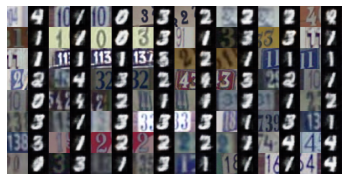

Epoch,Discriminator Loss,Generator Deception Loss,Generator Reconstruction Loss,Generator Loss,MNIST High Conf. Sample Count
99,0.0158,0.1264,0.0834,0.2098,29857


MNIST Test Split Final Classification Accuracy
87.2154


In [15]:
generator_discriminator_notebook_evaluator_evaluate_goals_and_print(generator_discriminator_trainer)